# Adamata Test Notebook

## Get python version

In [1]:
# This version will decide the version I will use
!python -V

Python 3.11.13


## Understanding the datasets a little bit

we're going to download the dataset given from google drive, we just going to use gdown and unzip to download then unzip it.

so...we got 12 images with respective label, and turns out the label is all the same despite the image is different.

```txt
class_id center_x center_y width height
```

if we see from YOLO annotation format, it looks that way, the label is all similar.

In [2]:
!pip install gdown

## 

## 

In [3]:
# download and extract given dataset
dataset_url = "https://drive.google.com/file/d/1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT/view?usp=sharing"
dataset_output_path = "/kaggle/working/sample.zip"
!gdown --fuzzy {dataset_url} -O {dataset_output_path}
!unzip {dataset_output_path}

Downloading...
From: https://drive.google.com/uc?id=1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT
To: /kaggle/working/sample.zip
100%|████████████████████████████████████████| 594k/594k [00:00<00:00, 1.76MB/s]
Archive:  /kaggle/working/sample.zip
   creating: sample/
  inflating: sample/raw-250110_dc_s001_b5_3.txt  
  inflating: sample/raw-250110_dc_s001_b5_2.txt  
  inflating: sample/raw-250110_dc_s001_b3_3.txt  
  inflating: sample/raw-250110_dc_s001_b3_4.txt  
  inflating: sample/raw-250110_dc_s001_b2_1.txt  
  inflating: sample/raw-250110_dc_s001_b5_5.jpg  
  inflating: sample/raw-250110_dc_s001_b4_3.txt  
  inflating: sample/raw-250110_dc_s001_b3_3.jpg  
  inflating: sample/raw-250110_dc_s001_b4_2.jpg  
  inflating: sample/raw-250110_dc_s001_b2_15.jpg  
  inflating: sample/raw-250110_dc_s001_b2_3.txt  
  inflating: sample/raw-250110_dc_s001_b5_2.jpg  
  inflating: sample/raw-250110_dc_s001_b4_2.txt  
  inflating: sample/raw-250110_dc_s001_b5_3.jpg  
  inflating: sample/raw-250110_dc_s001_b4_1

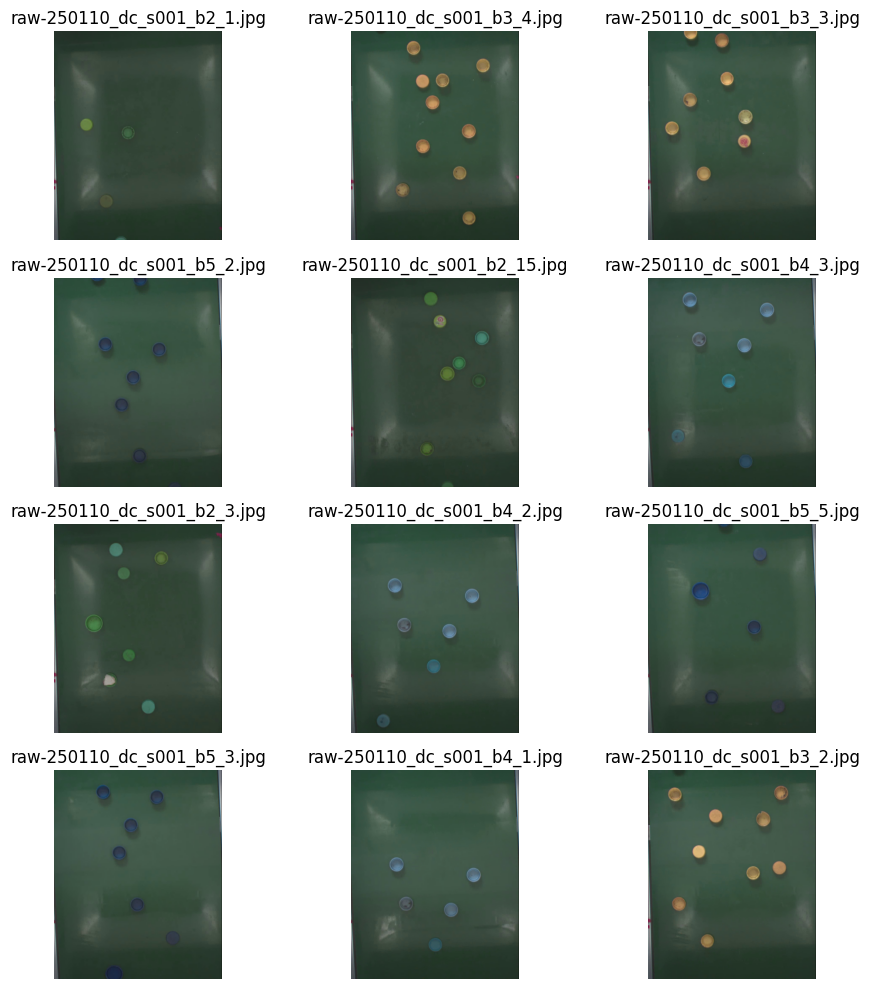

In [4]:
dataset_directory = "/kaggle/working/sample"

import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def display_images_from_directory(directory_path):
    """
    Opens a directory, identifies image files, and displays them in a grid.

    Args:
        directory_path (str): The path to the directory containing images.
    """
    image_files = []
    # Iterate through files in the specified directory
    for filename in os.listdir(directory_path):
        # Check if the file is an image (you can extend this list)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_files.append(os.path.join(directory_path, filename))

    if not image_files:
        print(f"No image files found in '{directory_path}'")
        return

    # Determine grid size for displaying images
    num_images = len(image_files)
    cols = int(num_images**0.5)  # Approximate square grid
    rows = (num_images + cols - 1) // cols # Calculate rows to fit all images

    plt.figure(figsize=(10, 10)) # Adjust figure size as needed

    for i, image_path in enumerate(image_files):
        try:
            img = Image.open(image_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(image_path)) # Display filename as title
            plt.axis('off') # Hide axes for cleaner display
        except Exception as e:
            print(f"Error opening or displaying '{image_path}': {e}")

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

# Example usage:
# Replace 'path/to/your/images' with the actual path to your directory
display_images_from_directory(dataset_directory)

In [5]:
def cat_txt_files_in_directory(directory_path):
    """
    Opens a directory and prints the content of all .txt files within it.

    Args:
        directory_path (str): The path to the directory to process.
    """
    path_obj = Path(directory_path)

    if not path_obj.is_dir():
        print(f"Error: '{directory_path}' is not a valid directory.")
        return

    print(f"Contents of .txt files in '{directory_path}':\n")
    found_txt_files = False

    for item in path_obj.iterdir():
        if item.is_file() and item.suffix == '.txt':
            found_txt_files = True
            print(f"--- {item.name} ---")
            try:
                with open(item, 'r', encoding='utf-8') as f:
                    print(f.read())
                print() # Add a newline for better separation between files
            except Exception as e:
                print(f"Error reading '{item.name}': {e}")
    
    if not found_txt_files:
        print("No .txt files found in this directory.")

cat_txt_files_in_directory(dataset_directory)

Contents of .txt files in '/kaggle/working/sample':

--- raw-250110_dc_s001_b2_1.txt ---
0 0.441375 0.488031 0.081350 0.060110
0 0.310675 0.815020 0.081350 0.061503
0 0.190663 0.447149 0.081350 0.060110


--- raw-250110_dc_s001_b5_2.txt ---
0 0.401112 0.604334 0.076400 0.059028
0 0.627238 0.342214 0.082450 0.068637
0 0.507606 0.852300 0.076412 0.059028
0 0.303069 0.315716 0.076412 0.059028
0 0.471450 0.475676 0.080725 0.068868


--- raw-250110_dc_s001_b3_3.txt ---
0 0.580294 0.410571 0.082912 0.068517
0 0.573362 0.528016 0.081475 0.064549
0 0.331531 0.683297 0.084413 0.068798
0 0.142925 0.465686 0.084225 0.066082
0 0.248981 0.330621 0.082912 0.068517
0 0.470419 0.227645 0.082912 0.068517
0 0.439994 0.046072 0.082913 0.068517
0 0.252356 0.019840 0.082913 0.039679


--- raw-250110_dc_s001_b4_2.txt ---
0 0.722281 0.345526 0.083263 0.069269
0 0.260806 0.294033 0.083262 0.069269
0 0.316725 0.483722 0.084250 0.068287
0 0.491844 0.681849 0.083087 0.066082
0 0.191506 0.941738 0.083262 0.063838

## Try plot the dataset with the bounding boxes

so the dataset is bunch of image with yolo annotated bounding boxes

lets try to plot it alongside the bounding boxes

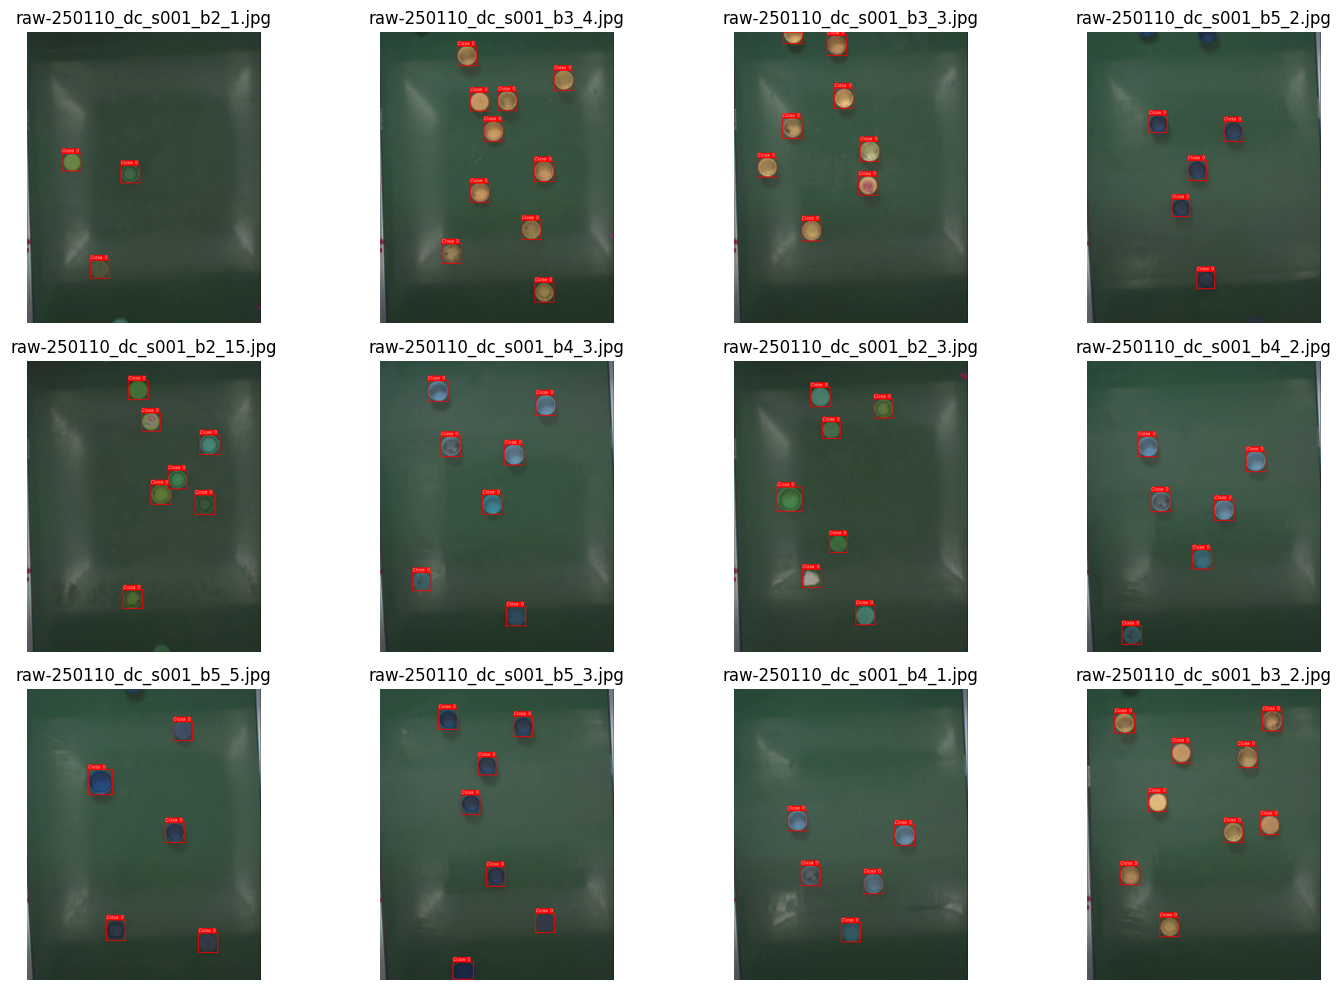

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def display_images_with_bboxes(directory_path):
    """
    Display images from a directory with YOLO format bounding boxes.
    
    Args:
        directory_path (str): Path to the directory containing jpg and txt files
    """
    dir_path = Path(directory_path)
    
    # Get all jpg files
    jpg_files = list(dir_path.glob("*.jpg"))
    
    if not jpg_files:
        print(f"No JPG files found in {directory_path}")
        return
    
    # Set up the plot
    fig = plt.figure(figsize=(15, 10))
    
    for i, jpg_path in enumerate(jpg_files):
        # Find corresponding txt file
        txt_path = jpg_path.with_suffix('.txt')
        
        if not txt_path.exists():
            print(f"Warning: No corresponding txt file for {jpg_path.name}")
            continue
            
        # Read image
        image = cv2.imread(str(jpg_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width = image.shape[:2]
        
        # Read bounding boxes from txt file
        with open(txt_path, 'r') as f:
            lines = f.readlines()
        
        # Draw bounding boxes
        for line in lines:
            data = line.strip().split()
            if len(data) >= 5:  # class_id, x_center, y_center, width, height
                class_id = int(data[0])
                x_center = float(data[1]) * img_width
                y_center = float(data[2]) * img_height
                width = float(data[3]) * img_width
                height = float(data[4]) * img_height
                
                # Calculate coordinates
                x1 = int(x_center - width/2)
                y1 = int(y_center - height/2)
                x2 = int(x_center + width/2)
                y2 = int(y_center + height/2)
                
                # Draw rectangle
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                
                # Add label with class ID
                label = f'Class {class_id}'
                label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                
                # Draw label background
                cv2.rectangle(image, (x1, y1 - label_size[1] - 5), 
                             (x1 + label_size[0], y1), (255, 0, 0), -1)
                
                # Draw label text
                cv2.putText(image, label, (x1, y1 - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Display image
        plt.subplot(3, 4, i+1)  # Adjust grid size as needed
        plt.imshow(image)
        plt.title(jpg_path.name)
        plt.axis('off')
        
        # Stop if we've displayed 12 images (adjust as needed)
        if i + 1 >= 12:
            break
    
    plt.tight_layout()
    plt.show()

# Usage example:
display_images_with_bboxes(dataset_directory)

## What we know from the dataset so far

- It hasnt labelled properly
- The bounding boxes is tight, so no need readjustment
- there's only 12 image, so might need augmentation
- it's not square, hate it
- and there's one image that miss one object

What we will do next is using [Roboflow](https://roboflow.com) to adjust the label, adding augmentation and little bit of preprocessing.

imo, it's ideal if we need non technical 

## Dataset augmentation, and using it.

Using Roboflow easy proprocess and augmentation, im able to convert 12 datasets image into 28(limited by Free Plan of Roboflow).

preprocess also squish the image size to 300x300 pixels

For datasets this size its easy to justify using SaaS like it, for the augmentation we pick this:

- Flip: Horizontal, Vertical
- Crop: 0% Minimum Zoom, 15% Maximum Zoom
- Rotation: Between -10° and +10°
- Brightness: Between -15% and +15%
- Blur: Up to 1.2px
- Noise: Up to 0.1% of pixels

This is to represent variation of images with range of realistic error and skewness of the camera.

The datasets also automatically splitted into 3 sets:

- 24 Training images
- 3 Validation images
- 1 Test image

The best part of using Roboflow is we can download the dataset using Curl, easy.

I honestly can do that by myself with little bit of code but Roboflow able to reformat the datasets into multiple annotation formats.

![Roboflow Screenshot](https://github.com/dhupee/adamata-ml-engineer-test/blob/master/img/Screenshot%202025-11-24%20at%2017-01-15%20dataset-annotation%20-%20v3%202-labeled-preprocessed-augmented.png)

## Picking model to be used

For easy life, YOLO is probably the most straight forward model to be used, from [Models from ultralytics](https://docs.ultralytics.com/models/) docs, I decided to use Yolov11n, for smallest model of the newest Yolov11.

In [7]:
# this dataset isnt inside directory so we need to make new directory
new_dataset_url = "https://app.roboflow.com/ds/Fz6f942UcB?key=qt4eGUWAQp"
new_dataset_path = "/kaggle/working/labelled.zip"
new_dataset_directory = "labelled"
!curl -L {new_dataset_url} > {new_dataset_path}
!mkdir {new_dataset_directory}
!unzip {new_dataset_path} -d {new_dataset_directory}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   904  100   904    0     0   1790      0 --:--:-- --:--:-- --:--:--  1793
100  166k  100  166k    0     0  73062      0  0:00:02  0:00:02 --:--:--  102k
Archive:  /kaggle/working/labelled.zip
  inflating: labelled/README.dataset.txt  
  inflating: labelled/README.roboflow.txt  
  inflating: labelled/data.yaml      
   creating: labelled/test/
   creating: labelled/test/images/
 extracting: labelled/test/images/raw-250110_dc_s001_b4_1_jpg.rf.a14b6d51da7363efdf299560f0721d30.jpg  
   creating: labelled/test/labels/
  inflating: labelled/test/labels/raw-250110_dc_s001_b4_1_jpg.rf.a14b6d51da7363efdf299560f0721d30.txt  
   creating: labelled/train/
   creating: labelled/train/images/
 extracting: labelled/train/images/raw-250110_dc_s001_b2_1_jpg.rf.b4c8714826298b17430b4f0e66a95b20.jpg  
 extracting: labelled/train/images/raw-25011

## Training the YOLO model

In [8]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━

In [9]:
from ultralytics import YOLO

data_path = "/kaggle/working/labelled/data.yaml"
image_size = 300
model = YOLO("yolo11n.pt")
results = model.train(data=data_path, epochs=100, imgsz=image_size)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.232 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/labelled/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=300, int8=Fals

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all          3         18      0.989          1      0.995        0.8
             dark-blue          2         11      0.993          1      0.995      0.763
                others          1          7      0.985          1      0.995      0.836
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/train
